#Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3aac593b70e434c08bccb46f85f0a1d13c4b0ae3e1805d2287252d82f23263f8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6432cee44e98fa67e549ae52647aecd025ccc8ff88d2c88c7d33281fbed51809
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 39.68 MiB/s, done.
Resolving deltas: 100% (3/3), done.


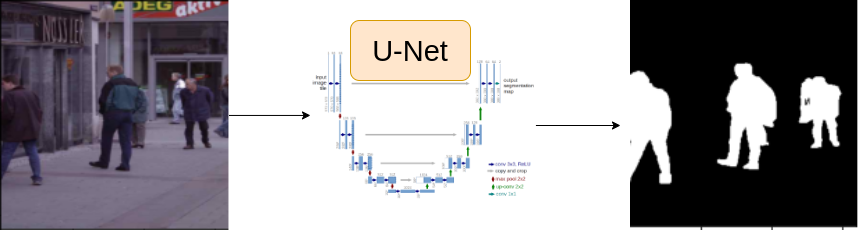

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.loc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

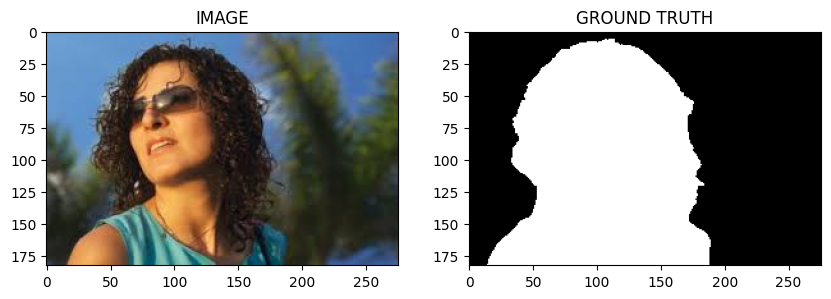

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

#  Augmentation Functions

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentation):

    self.df = df
    self.augmentation = augmentation
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentation:
      data = self.augmentation(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    # (h, w, c) -> (c, h ,w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    # NP to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


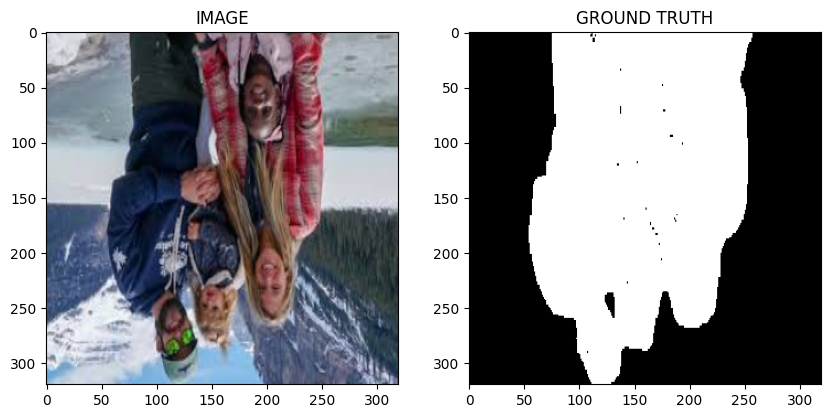

In [16]:
idx = 2
image, mask = trainset[idx]
helper.show_image(image, mask)

#  Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f'total no. of batches in trainloader: {len(trainloader)}')
print(f'total no. of batches in validloader: {len(validloader)}')

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [29]:

print(image.shape)
print(mask.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


#  Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 155MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

#  Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/ len(data_loader)

In [32]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss/ len(data_loader)

#  Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [34]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('saved model')
    best_valid_loss = valid_loss
  print(f'Epoch {i+1} Train loss: {train_loss}  Valid loss: {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


saved model
Epoch 1 Train loss: 0.37164568702379863  Valid loss: 0.5215053930878639


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


saved model
Epoch 2 Train loss: 0.3435259242852529  Valid loss: 0.37079331278800964


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


saved model
Epoch 3 Train loss: 0.2670548011859258  Valid loss: 0.2556699514389038


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


saved model
Epoch 4 Train loss: 0.2783820499976476  Valid loss: 0.23879443854093552


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


saved model
Epoch 5 Train loss: 0.20455635488033294  Valid loss: 0.23800738528370857


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 6 Train loss: 0.22001011272271473  Valid loss: 0.23923053592443466


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch 7 Train loss: 0.17113817731539407  Valid loss: 0.23917365074157715


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


saved model
Epoch 8 Train loss: 0.17201266437768936  Valid loss: 0.18586274608969688


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch 9 Train loss: 0.1522646153966586  Valid loss: 0.20335130766034126


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


saved model
Epoch 10 Train loss: 0.17062768042087556  Valid loss: 0.18324213102459908


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Epoch 11 Train loss: 0.13888100733359654  Valid loss: 0.184373389929533


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch 12 Train loss: 0.13815386344989142  Valid loss: 0.22878065705299377


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch 13 Train loss: 0.13603418171405793  Valid loss: 0.24680333584547043


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 14 Train loss: 0.12232498923937479  Valid loss: 0.20745539292693138


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 15 Train loss: 0.13372083355983097  Valid loss: 0.20592369139194489


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch 16 Train loss: 0.13861422191063563  Valid loss: 0.20128532499074936


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch 17 Train loss: 0.12486588855584463  Valid loss: 0.2370079606771469


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch 18 Train loss: 0.15450670967499416  Valid loss: 0.26615697890520096


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch 19 Train loss: 0.15314456671476365  Valid loss: 0.18996337801218033


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch 20 Train loss: 0.13435262938340506  Valid loss: 0.21820591017603874


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch 21 Train loss: 0.12708198775847754  Valid loss: 0.2287231869995594


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 22 Train loss: 0.13094511379798254  Valid loss: 0.1906217820942402


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


saved model
Epoch 23 Train loss: 0.09535381744305292  Valid loss: 0.1755305975675583


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch 24 Train loss: 0.09712236374616623  Valid loss: 0.2070072703063488


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

Epoch 25 Train loss: 0.10188586264848709  Valid loss: 0.24379242211580276


# Task 9 : Inference

In [36]:
idx = 20
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

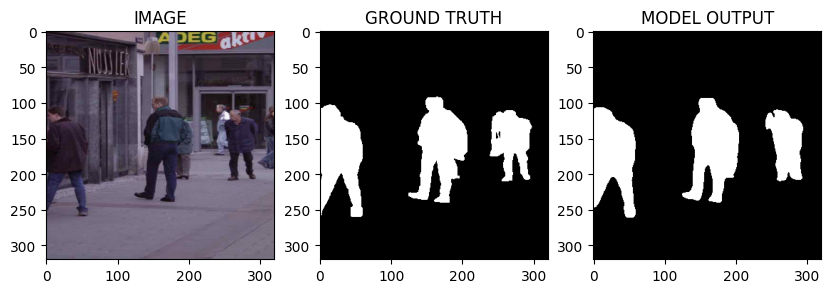

In [37]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

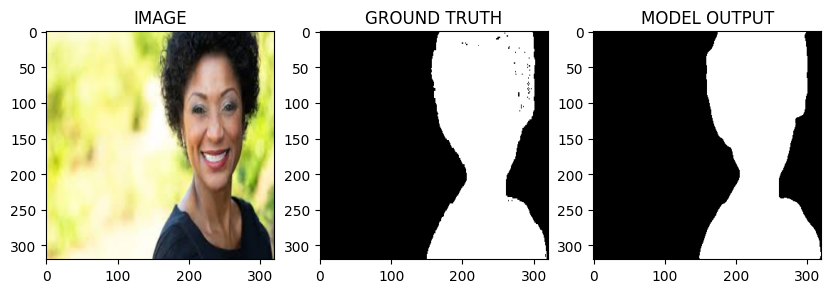

In [39]:
idx = 2
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))